In [125]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import geopandas
import geoplot
import geoplot.crs as gcrs

import json
import seaborn as sns

In [136]:
yield_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\adm_crop_data_raw_KE.csv')
yield_data = yield_data.loc[~((yield_data['product'] != 'Maize Grain (Fresh)')*(yield_data['product'] != 'Maize Grain (White)'))]
yield_data = yield_data.loc[yield_data['data_usage_policy'] == 'Public']
#yield_data = yield_data.loc[(yield_data['indicator'] == 'Yield') | (yield_data['indicator'] == 'Quantity Produced')]
#yield_data = yield_data.loc[(yield_data['indicator'] == 'Quantity Produced')]
yield_data = yield_data.drop(['status_changed', 'collection_status_changed', 'Unnamed: 0','created', 'modified'], axis=1)
publication_columns = ['source_document', 'publication_name', 'dataseries', 'dataseries_name', 'collection_date']
moot_cols = ['geographic_group', 'fewsnet_region',
             'country', 'country_code', 'admin_0', 'admin_3', 'admin_4', 
             'specialization_type', 'dataseries_specialization_type',
            'collection_status', 
            'source_organization', 
            'document_type', 'preference_rating', 'indicator_group', 'status', 
            'collection_schedule', 
            'data_usage_policy', 'submitted_by', 'planting_start_date', 
            'planting_end_date', 'harvest_start_date', 'harvest_end_date', 
            'vegetative_start_date', 'vegetative_end_date', 'reproductive_start_date', 
            'reproductive_end_date', 'datasourcedocument', 'datasourceorganization',
            'population_group', 'crop_production_system',
            'season_name', 'season_type']
unsure_cols = ['cpcv2', 'cpcv2_description', 'datacollectionperiod', 'datacollection',
               'indicator_abbreviation', 'locality', 'season', 'dataseries']
yield_data = yield_data.drop(moot_cols + publication_columns + unsure_cols, axis=1)
for date_col in ['start_date', 'period_date', 'season_date']:
    yield_data.loc[:, date_col] = pd.to_datetime(yield_data.loc[:, date_col])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_16316\4238206181.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  yield_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\adm_crop_data_raw_KE.csv')


In [57]:
#fig, ax = plt.subplots()
#sns.barplot(data = yield_data, x = 'admin_1', y='value', estimator = 'mean', errorbar = 'sd', ax=ax)
#ax.tick_params(axis='x', labelrotation=90)

In [79]:
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country', 'admin_0',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)
adm_data = adm_data.explode()#.crs
adm_data.loc[:, 'centroid'] = adm_data.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')
adm_data_for_merging = adm_data.drop_duplicates(subset = ['fnid']).drop(columns=['admin_1', 'admin_2', 'start_date', 'id'])
yield_data_polygons = adm_data_for_merging.merge(yield_data, on=['fnid'], how='right')#yield_data.merge(, on=['fnid'], how='left')#, validate='one_to_many')

Skipping field centroid: unsupported OGR type: 3


In [118]:
yield_data_mean = yield_data.loc[(yield_data['indicator'] == 'Yield')]
yield_data_mean = yield_data_mean.loc[:, ['geographic_unit_name', 'value']].groupby('geographic_unit_name').mean()
yield_data_mean = adm_data_for_merging.merge(yield_data_mean, left_on=['name'], right_on = ['geographic_unit_name'], how='right')

yield_data_std = yield_data.loc[(yield_data['indicator'] == 'Yield')]
yield_data_std = yield_data_std.loc[:, ['geographic_unit_name', 'value']].groupby('geographic_unit_name').std()
yield_data_std = adm_data_for_merging.merge(yield_data_std, left_on=['name'], right_on = ['geographic_unit_name'], how='right')

In [119]:
len(yield_data_mean)

55

In [138]:
yield_data#['indicator'].unique()

,geographic_unit_full_name,geographic_unit_name,fnid,admin_1,admin_2,start_date,period_date,season_date,season_year,indicator,value,population,value_per_capita,product,locality_name,unit,unit_name,id,geographic_unit
13278,"Kirinyaga, Central, Kenya",Kirinyaga,KE1982A24802,Central,Kirinyaga,1988-12-01 00:00:00,1988-12-31 00:00:00,1988-01-01 00:00:00,Annual harvest 1988,Area Harvested,31284.000000,NaN,NaN,Maize Grain (White),"Kirinyaga, Central, Kenya (01/01/1982 - 12/31/...",ha,hectare,37215087,48007
13281,"Kirinyaga, Central, Kenya",Kirinyaga,KE1982A24802,Central,Kirinyaga,1987-12-01 00:00:00,1987-12-31 00:00:00,1987-01-01 00:00:00,Annual harvest 1987,Area Harvested,36545.920424,NaN,NaN,Maize Grain (White),"Kirinyaga, Central, Kenya (01/01/1982 - 12/31/...",ha,hectare,37215327,48007
13284,"Kirinyaga, Central, Kenya",Kirinyaga,KE1982A24802,Central,Kirinyaga,1986-12-01 00:00:00,1986-12-31 00:00:00,1986-01-01 00:00:00,Annual harvest 1986,Area Harvested,33479.000000,NaN,NaN,Maize Grain (White),"Kirinyaga, Central, Kenya (01/01/1982 - 12/31/...",ha,hectare,37215739,48007
13287,"Kirinyaga, Central, Kenya",Kirinyaga,KE1982A24802,Central,Kirinyaga,1985-12-01 00:00:00,1985-12-31 00:00:00,1985-01-01 00:00:00,Annual harvest 1985,Area Harvested,27425.000000,NaN,NaN,Maize Grain (White),"Kirinyaga, Central, Kenya (01/01/1982 - 12/31/...",ha,hectare,37216224,48007
13290,"Kirinyaga, Central, Kenya",Kirinyaga,KE1982A24802,Central,Kirinyaga,1984-12-01 00:00:00,1984-12-31 00:00:00,1984-01-01 00:00:00,Annual harvest 1984,Area Harvested,32046.000000,NaN,NaN,Maize Grain (White),"Kirinyaga, Central, Kenya (01/01/1982 - 12/31/...",ha,hectare,37217409,48007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51547,"Nairobi, Kenya",Nairobi,KE2013A147,Nairobi,NaN,2017-12-01 00:00:00,2017-12-31 00:00:00,2017-01-01 00:00:00,Annual harvest 2017,Yield,0.650679,3876583.0,1.678486e-07,Maize Grain (White),"Nairobi, Kenya (From 01/01/2013): All sectors ...",MT/ha,tonnes per hectare,37237784,3105
51558,"Nairobi, Kenya",Nairobi,KE2013A147,Nairobi,NaN,2016-12-01 00:00:00,2016-12-31 00:00:00,2016-01-01 00:00:00,Annual harvest 2016,Yield,1.099581,3859440.0,2.849068e-07,Maize Grain (White),"Nairobi, Kenya (From 01/01/2013): All sectors ...",MT/ha,tonnes per hectare,37234934,3105
51569,"Nairobi, Kenya",Nairobi,KE2013A147,Nairobi,NaN,2015-12-01 00:00:00,2015-12-31 00:00:00,2015-01-01 00:00:00,Annual harvest 2015,Yield,1.258977,3788864.0,3.322835e-07,Maize Grain (White),"Nairobi, Kenya (From 01/01/2013): All sectors ...",MT/ha,tonnes per hectare,37234382,3105
51578,"Nairobi, Kenya",Nairobi,KE2013A147,Nairobi,NaN,2014-12-01 00:00:00,2014-12-31 00:00:00,2014-01-01 00:00:00,Annual harvest 2014,Yield,0.810296,3714605.0,2.181378e-07,Maize Grain (White),"Nairobi, Kenya (From 01/01/2013): All sectors ...",MT/ha,tonnes per hectare,37236619,3105


In [80]:
yield_data_polygons = yield_data_polygons.loc[(yield_data_polygons['indicator'] == 'Yield')]# | (yield_data_polygons['indicator'] == 'Quantity Produced')]

In [76]:
yield_data_polygons.columns.to_list()

['fnid',
 'name',
 'unit_type_code',
 'parent_id',
 'p_code',
 'full_name',
 'unit_type',
 'layer_name',
 'area',
 'attributes',
 'fid',
 'geometry',
 'centroid',
 'geographic_unit_full_name',
 'geographic_unit_name',
 'admin_1',
 'admin_2',
 'start_date',
 'period_date',
 'season_date',
 'season_year',
 'indicator',
 'value',
 'population',
 'value_per_capita',
 'product',
 'locality_name',
 'unit',
 'unit_name',
 'id',
 'geographic_unit']

In [120]:
#for year in range(1975, 2025):
#    obsnum = len(yield_data_polygons.loc[yield_data_polygons['season_year'] == f'Annual harvest {year}'])
#    print(f'Year {year}: {obsnum}')
for_plotting = yield_data_polygons.loc[yield_data_polygons['season_year'] == 'Annual harvest 2020']#.columns.to_list()
#geoplot.polyplot(for_plotting)
fig, ax = plt.subplots()
yield_plot = geoplot.choropleth(for_plotting, hue='value', cmap='Oranges', ax=ax, legend=True)
#plt.colorbar(yield_plot)

KeyError: 'season_year'

In [121]:
yield_data_mean.head()#.columns.to_list()#['name']

,fnid,name,unit_type_code,parent_id,p_code,full_name,unit_type,layer_name,area,attributes,fid,geometry,centroid,value
0,KE2013A130,Baringo,admin1,3413.0,KE030,"Baringo, Kenya",Admin 1,KE_Admin1_2013,10889.0,"{ ""FNID"": ""KE2013A130"", ""ADMIN0"": ""Kenya"", ""AD...",0.0,"POLYGON ((35.78634 1.65376, 35.79574 1.63857, ...",POINT (35.9465 0.6691),1.997492
1,KE2013A136,Bomet,admin1,3413.0,KE036,"Bomet, Kenya",Admin 1,KE_Admin1_2013,2371.0,"{ ""FNID"": ""KE2013A136"", ""ADMIN0"": ""Kenya"", ""AD...",1.0,"POLYGON ((35.50717 -0.45543, 35.51272 -0.46446...",POINT (35.29861 -0.72643),2.010546
2,KE2013A139,Bungoma,admin1,3413.0,KE039,"Bungoma, Kenya",Admin 1,KE_Admin1_2013,3023.0,"{ ""FNID"": ""KE2013A139"", ""ADMIN0"": ""Kenya"", ""AD...",2.0,"POLYGON ((34.61809 1.10215, 34.62033 1.10018, ...",POINT (34.64023 0.7501),2.549085
3,KE2013A140,Busia,admin1,3413.0,KE040,"Busia, Kenya",Admin 1,KE_Admin1_2013,1832.0,"{ ""FNID"": ""KE2013A140"", ""ADMIN0"": ""Kenya"", ""AD...",3.0,"POLYGON ((34.36917 0.77053, 34.37295 0.76973, ...",POINT (34.19236 0.386),1.287249
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,2.015000


<Axes: >

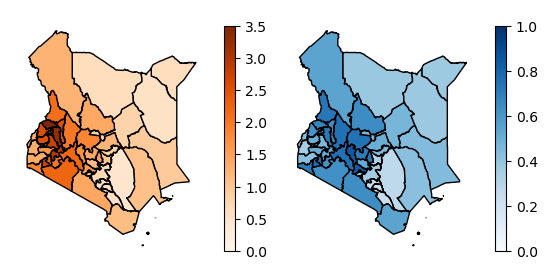

In [133]:
fig, axs = plt.subplots(1, 2)
norm = mpl.colors.Normalize(vmin=0.,vmax=3.5)
geoplot.choropleth(yield_data_mean.dropna(), hue='value', cmap='Oranges', ax=axs[0], legend=True, norm=norm, legend_kwargs={'fraction': 0.05})
norm = mpl.colors.Normalize(vmin=0.,vmax=1)
geoplot.choropleth(yield_data_std.dropna(), hue='value', cmap='Blues', ax=axs[1], legend=True, norm=norm, legend_kwargs={'fraction': 0.05})

In [86]:
yield_data_polygons.columns.to_list()

['fnid',
 'name',
 'unit_type_code',
 'parent_id',
 'p_code',
 'full_name',
 'unit_type',
 'layer_name',
 'area',
 'attributes',
 'fid',
 'geometry',
 'centroid',
 'geographic_unit_full_name',
 'geographic_unit_name',
 'admin_1',
 'admin_2',
 'start_date',
 'period_date',
 'season_date',
 'season_year',
 'indicator',
 'value',
 'population',
 'value_per_capita',
 'product',
 'locality_name',
 'unit',
 'unit_name',
 'id',
 'geographic_unit']

In [85]:
mean_yields = yield_data_polygons.groupby('fnid').mean()

TypeError: agg function failed [how->mean,dtype->object]

In [78]:
for_plotting['value']

2894      802.980000
2903        1.325050
2912    34060.740000
2921        0.602035
2930    44584.630000
            ...     
3695        1.973525
3704    67562.750000
3713        1.581155
3722      971.840000
3731        1.421650
Name: value, Length: 94, dtype: float64

In [ ]:
#adm_data.apply(lambda srs: eval(srs[13])['FNID'], axis = 1)#.iloc[0, 13]['attributes']['FNID']

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_16316\1942946816.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adm_data.apply(lambda srs: eval(srs[13])['FNID'], axis = 1)#.iloc[0, 13]['attributes']['FNID']


0      KE2013A101
0      KE2013A101
0      KE2013A101
0      KE2013A101
0      KE2013A101
          ...    
337    KE2013A130
337    KE2013A130
337    KE2013A130
337    KE2013A130
337    KE2013A130
Length: 650, dtype: object

In [20]:
geom = adm_data.pop('geometry')
geom = geom.apply(lambda x: list(x) if isinstance(x, geopandas.MultiPolygon) else x).explode()
adm_data = adm_data.join(geom, how='inner')

AttributeError: module 'geopandas' has no attribute 'MultiPolygon'

<Axes: >

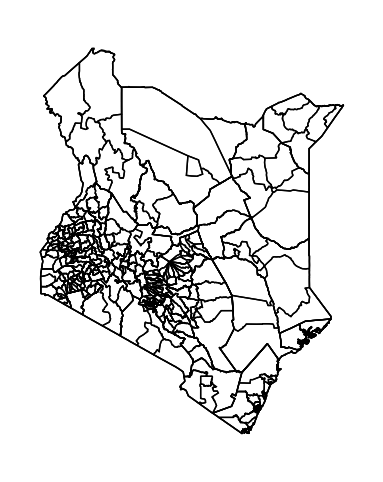

In [97]:
#yield_data[['admin_2', 'value']].groupby('admin_2').std()

In [ ]:
sns.barplot(yield_data.groupby('fnid'))